In [91]:
%matplotlib inline

import distributed
from dask.distributed import Client, progress
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import numpy as np
import pandas as pd
import uproot
import backports.lzma

import sys
sys.path.insert(0,"../")
import utils
import glob
import uproot_methods
import matplotlib.pyplot as plt

utils.bokeh_output_notebook()

Loading BokehJS ...

### useful links
* [custom use cases](https://webcache.googleusercontent.com/search?q=cache:ibMAJ_NTsgAJ:https://github.com/dask/dask/blob/master/docs/source/use-cases.rst+&cd=6&hl=en&ct=clnk&gl=us)
* [profiling/scaling](http://matthewrocklin.com/blog/work/2017/07/03/scaling)

In [92]:
c = Client("uaf-1.t2.ucsd.edu:50123")
c

Client Scheduler: tcp://uaf-1.t2.ucsd.edu:50123 Dashboard: http://uaf-1.t2.ucsd.edu:8787/status,Cluster Workers: 30 Cores: 30 Memory: 240.00 GB


In [93]:
%%html
<iframe src="http://localhost:8787/status" width="100%" height="500px"></iframe>

Initialize a cache for branches and also one for tree objects on each worker

In [164]:
def initialize_arraycache():
    from distributed import get_worker
    import uproot
    worker = get_worker()
    worker.cache = uproot.ArrayCache("6 GB")
    worker.treecache = {}
    
c.run(initialize_arraycache);

Register a custom metric for the dashboard "Workers" tab
to report the uproot ArrayCache size, and also the number of
tree objects we have cached. Dask distributed web info [here](https://distributed.readthedocs.io/en/latest/web.html).

In [165]:
def cachesize_metric():
    def f(worker):
        if hasattr(worker,"cache"):
            return "{:.2f}GB".format(worker.cache._cache.currsize/1e9)
        return 0
    return f

def treecache_metric():
    def f(worker):
        if hasattr(worker,"treecache"):
            return len(list(worker.treecache.keys()))
        return 0
    return f

def register_metrics(dask_worker):
    dask_worker.metrics["cachesize"] = cachesize_metric()
    dask_worker.metrics["treecache"] = treecache_metric()

c.run(register_metrics);

In [166]:
%%time
futures = c.map(lambda x:x, range(100),pure=False)
np.array(c.gather(futures)).shape

CPU times: user 46 ms, sys: 7 ms, total: 53 ms
Wall time: 210 ms


(100,)

In [167]:
fnames = sorted(glob.glob("/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run*/*.root"))[:100]
chunks, total_nevents = utils.get_chunking(tuple(fnames),int(1.0e6))
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

223 chunks of 100 files, with a total of 1.7276e+08 events


In [168]:
%%time
def get_hist(args):
    fname,entrystart,entrystop = args
    try:
        from distributed import get_worker
        worker = get_worker()
        # array cache
        cache = worker.cache
        # also cache the tree object (otherwise opening file+getting tree is ~0.7s overhead)
        if fname in worker.treecache:
            t = worker.treecache[fname]
        else:
            f = uproot.open(fname)
            t = f["Events"]
            worker.treecache[fname] = t
    except:
        cache = None
        f = uproot.open(fname)
        t = f["Events"]
    extra = dict(outputtype=tuple,namedecode="ascii",entrystart=entrystart,entrystop=entrystop,cache=cache)
    mus = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        *t.arrays(["Muon_pt","Muon_eta","Muon_phi","Muon_mass"],**extra)
    )
    mus = mus[mus.counts==2]
    mll = (mus[:,0]+mus[:,1]).mass
    bins = np.logspace(np.log10(0.5),np.log10(1000),num=300)
    counts,_ = np.histogram(np.clip(mll,bins[0],bins[-1]),bins=bins)
    return counts

x = get_hist((chunks[0][0],chunks[0][1],chunks[0][2]//20))
x.sum()

CPU times: user 1.01 s, sys: 74 ms, total: 1.08 s
Wall time: 1.69 s


5489

Run the invariant mass example. `pure=False` to prevent dask caching results, so that we can run multiple times for studying purposes.

In [169]:
%%time
futures = c.map(get_hist,chunks,pure=False)
results = c.gather(futures)
len(results)

CPU times: user 1.45 s, sys: 131 ms, total: 1.58 s
Wall time: 1min 40s


223

Get the task stream from the scheduler (only the last `len(futures)` tasks, to correspond to the previous `map`).
Then plot the tasks stream and an estimate of the event rate, which additionally needs the chunking information.

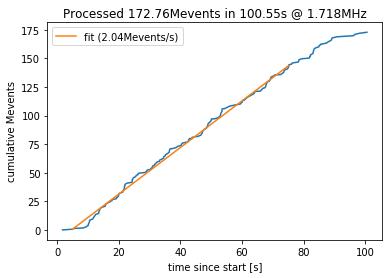

In [170]:
utils.plot_timeflow(c.get_task_stream(count=len(futures)))
utils.plot_cumulative_events(c.get_task_stream(count=len(futures)),futures,chunks)

OK, that was fast. Now get the list of workers that were used in the same order as the chunking.
We use this in another `map` call. To take advantage of caching, each chunk gets sent to the worker 
that ran it previously.

In [171]:
d = c.who_has(futures)
workers = [set(d[f.key]) for f in futures]

In [172]:
futures = c.map(get_hist,chunks,workers=workers,pure=False)

In [173]:
# asynchronous progress bar. Don't really need it if the monitoring page is above
progress(futures)

VBox()

In [174]:
results = c.gather(futures)

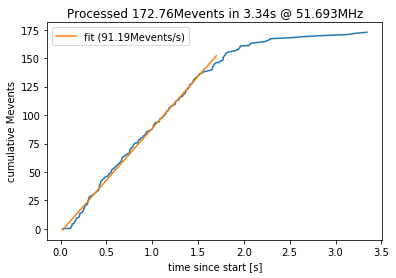

In [175]:
utils.plot_timeflow(c.get_task_stream(count=len(futures)))
utils.plot_cumulative_events(c.get_task_stream(count=len(futures)),futures,chunks)

OK, that was faster, as it should be. Each task returned histogrammed bin counts, so we sum them up and plot.

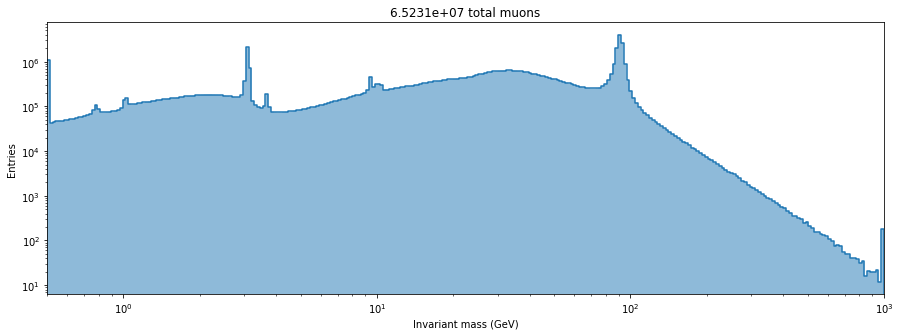

In [176]:
bins = np.logspace(np.log10(0.5),np.log10(1000),num=300)
counts = sum(results)

fig,ax = plt.subplots(figsize=(15,5))
ax.step(x=bins, y=np.append(counts,0), where="post")
ax.fill_between(x=bins, y1=np.append(counts,0), step="post",alpha=0.5)
ax.set_xlim(bins[0],bins[-1])
# ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel("Invariant mass (GeV)")
ax.set_title("{:.5g} total muons".format(counts.sum()))
ax.set_ylabel("Entries");
ax.set_xscale("log")
ax.set_yscale("log")